# Testing augmentation and splitting the data

In [1]:
from matplotlib.colors import  LinearSegmentedColormap
from skimage.transform import resize, downscale_local_mean, rescale
from tensorflow.keras.utils import to_categorical

from skimage import filters
import matplotlib.pyplot as plt 
from random import randint
from scipy import ndimage as nd
from skimage import transform
import scipy.linalg as la
import tensorflow as tf
import pandas as pd
from scipy import ndimage
from skimage import filters
import nibabel as nib
import numpy as np
import scipy as sp
import utils_prepr as ut
import main_augmentation as augment
import scipy
import os 

import matplotlib.gridspec as gridspec
import random


tran = 0.8
colorsM = [(0, 0, 0, 0), (1,  0.30196078,  0., tran), (1  ,  0.39,  0.39, tran)]  # (R,G,B,T)
cmap_name = 'my_list'
cmc = LinearSegmentedColormap.from_list(cmap_name, colorsM, N=3)


In [2]:
# Function for data path collection
def get_wmls_path_list(dataset_dir):
    t1, flair, mask = [], [], []
    for subdir, dirs, files in os.walk(dataset_dir):
        for file in files:
            file_path = subdir + '/' + file # change to '\\' if using Windows
            if file_path.endswith("wmh.nii.gz"): # change to '\\' if using Windows
                mask.append(file_path) 
            elif file_path.endswith("T1.nii.gz"): # change to '\\' if using Windows
                t1.append(file_path) 
            elif file_path.endswith("FLAIR.nii.gz"): # change to '\\' if using Windows
                flair.append(file_path) 
    return np.array([np.array(t1), np.array(flair), np.array(mask)])


## Load the path array

In [3]:
dataset_dir = '/Users/elena/Documents/data/train'
path_array = get_wmls_path_list(dataset_dir)
path_array.shape

(3, 105)

## Augmenting data in the pipeline

(3, 240, 240, 48)


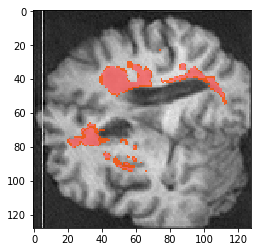

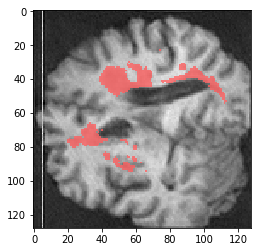

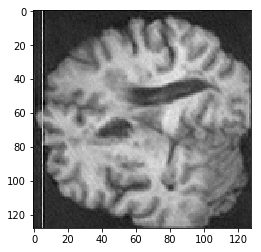

(3, 132, 256, 83)


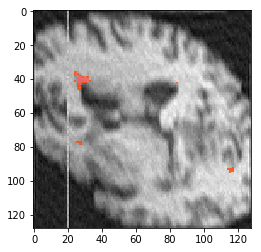

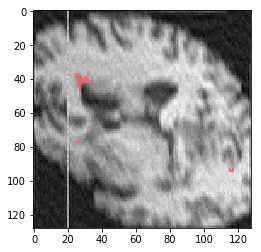

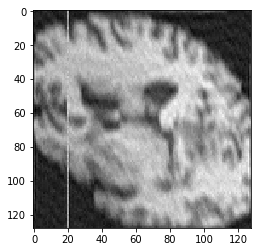

-->final DATA FORMAT AND TYPE: (2, 1, 128, 128, 128, 2)


In [6]:

input_shape = (128, 128, 128, 1)
x_dim = input_shape[0] 
y_dim = input_shape[1]
z_dim = input_shape[2]

output_classes = 2
x_data, y_data = [], []
for _ in range(0,2):
    volume = ut.load_file(path_array)
    volume = np.squeeze(volume).astype('float')
    print(volume.shape)
    volume[2][volume[2]>0] = 1
    # cropping
    mask = ut.thr_cuboid(volume[0])
    volume, indx = ut.get_cuboid(volume, mask)
    volume, affMAt = augment.augment(volume)
    # bi-cubic interpolation
    x = resize(volume[0], [x_dim, y_dim, z_dim, 1], order=3, anti_aliasing=True)
    x_t1 = resize(volume[1], [x_dim, y_dim, z_dim, 1], order=3, preserve_range=True)
    x = np.stack((x_t1,x), axis=3)
    x = np.squeeze(x, axis=4)
    x = ut.rescale(x,max=255) # intensity normalisation

    y = resize(np.array(volume[2]), [x_dim, y_dim, z_dim, 1], order=3, anti_aliasing=True)
    plt.imshow(x[:,:,68,1], "gray")
    plt.imshow(y[:,:,68,0], cmc)
    plt.show()
    th = 0.3
    y[y>=th] = 1
    y[y<th] = 0
    y = ut.prepare_y(y)
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)

    plt.imshow(x[0,:,:,68,1], "gray")
    plt.imshow(y[0,:,:,68,1], cmc)
    plt.show()
    plt.imshow(x[0,:,:,68,1], "gray")
    plt.show()

    x_data.append(x)
    y_data.append(y)
    

x_data = np.array(x_data)
print('-->final DATA FORMAT AND TYPE: {}'.format(x_data.shape))
y_data = np.array(y_data)

## Splitting the data

In [7]:
dataset_dir = '/Users/elena/Documents/data/train'
path_array = get_wmls_path_list(dataset_dir)
path_array.shape

(3, 105)

## Using kfold object to select train/val/test ids and save them into txt files 

In [24]:
from sklearn.model_selection import KFold

num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_idx, test_idx in kfold.split(path_array[1]):
    # SAVE test IDS FOR EVERY FOLD IN TXT. 
    np.savetxt("ids/"+str(fold_no)+'_test_ids.txt', test_idx, fmt='%d')
        
    print('\nFold ', fold_no)

    x = int(len(train_idx)*0.2)
    train_idx, val_idx = train_idx[:-x], train_idx[-x:]
    np.savetxt("ids/"+str(fold_no)+'_train_ids.txt', train_idx, fmt='%d') # save train ids
    np.savetxt("ids/"+str(fold_no)+'_val_ids.txt', val_idx, fmt='%d') # save test ids


    X_train_cv = path_array[:,train_idx]
    X_valid_cv = path_array[:,val_idx]
    print(X_train_cv.shape) # print size of the train set
    print(X_valid_cv.shape) # print size of the val set
    # Increase fold number
    fold_no = fold_no + 1


Fold  1
(3, 68)
(3, 16)

Fold  2
(3, 68)
(3, 16)

Fold  3
(3, 68)
(3, 16)

Fold  4
(3, 68)
(3, 16)

Fold  5
(3, 68)
(3, 16)


In [11]:
train_idx

array([ 0,  1,  3,  4,  6,  8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21,
       22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 61, 62,
       64, 66, 67, 68, 69, 71, 73, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86])

In [12]:
val_idx

array([ 87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98, 101,
       102, 103, 104])

In [13]:
test_idx

array([  2,   5,   7,   9,  16,  25,  29,  35,  36,  53,  55,  60,  63,
        65,  70,  72,  74,  80,  84,  99, 100])

Show the train ids in folds 3-5

In [33]:
for i in np.arange(3,6):
    b = np.loadtxt('ids/'+str(i)+'_train_ids.txt', dtype=int)

    print(b)

[ 0  2  3  5  7  8 10 11 12 13 14 17 18 19 22 23 24 25 27 28 29 30 31 32
 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58
 60 61 62 63 65 67 69 70 71 72 73 76 77 78 79 80 81 82 83 84]
[ 0  1  2  3  4  5  6  9 10 11 13 15 16 18 19 20 21 22 23 24 25 26 29 30
 31 32 34 35 36 37 38 40 42 43 44 45 46 47 49 50 51 52 53 54 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 77 78 79 81 82]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 33 35 36 37 38 39 40 41 44 45 46 47 48 49 50 52 55 56 57 59 60
 62 63 64 65 66 67 68 69 70 71 73 74 75 76 77 78 79 80 81 82]
